# Cavity LDOS Bounds: Cartesian vs Polar Coordinates

This notebook demonstrates how to compute limits using the Polar coordinate formulation in Dolphindes. To verify consistency, we also compare the results with the Cartesian coordinate formulation.

In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys, time, os

from dolphindes import photonics
from dolphindes.cvxopt import gcd
from dolphindes.maxwell import plot_real_polar_field, expand_symmetric_field, TM_Polar_FDFD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem Setup

We consider a 2D TM problem. We want to maximize the LDOS at the center of a circular design region. 
The design region is an annulus $R_{in} < r < R_{out}$.
We place a point source at the center.

In [2]:
wavelength = 1.0
omega = 2 * np.pi / wavelength
chi = 4 + 1e-4j

# Geometry parameters
R_inner = 0.2
R_outer = 0.6
Npml = 10
gpr = 50
dl = 1/gpr

## 1. Cartesian Coordinates

This should look pretty much identical to prior tutorials. We are just getting the cartesian value.

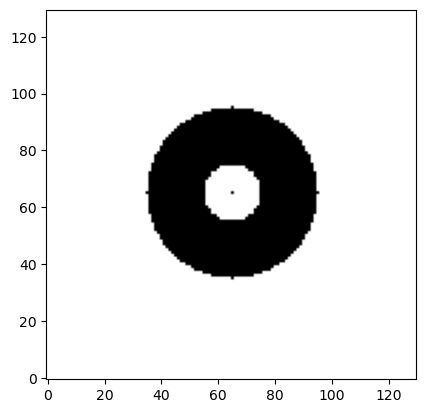

In [3]:
# Grid setup
L_domain = 2 * (R_outer + 0.5)
Nx = Ny = int(L_domain / dl) + 2 * Npml

# Source at center
ji_cart = np.zeros((Nx, Ny), dtype=complex)
cx, cy = Nx // 2, Ny // 2
ji_cart[cx, cy] = 1.0 / dl**2

# Design mask (Annulus)
x = (np.arange(Nx) - cx) * dl
y = (np.arange(Ny) - cy) * dl
X, Y = np.meshgrid(x, y, indexing='ij')
R = np.sqrt(X**2 + Y**2)
des_mask_cart = (R >= R_inner) & (R <= R_outer)
ndof = np.sum(des_mask_cart)

chi_bg_cart = np.zeros((Nx, Ny), dtype=complex)
plt.imshow(des_mask_cart.T + np.real(ji_cart.T).astype(bool), origin='lower', cmap='Greys')

Cartesian Vacuum LDOS: 0.7870
Precomputed 2 A matrices and Fs vectors.


/home/alessio/code/dolphindes/dolphindes/photonics/_base_photonics.py:405: UserWarning: If both ji and ei are specified then ji is ignored.
  warnings.warn("If both ji and ei are specified then ji is ignored.")
/home/alessio/code/dolphindes/dolphindes/cvxopt/qcqp.py:162: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  self.Acho = sksparse.cholmod.analyze(A)
/home/alessio/code/dolphindes/dolphindes/cvxopt/qcqp.py:207: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  tmp = self.Acho.cholesky(A)
/home/alessio/code/dolphindes/dolphindes/cvxopt/qcqp.py:173: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  self.Acho.cholesky_inplace(A)


Found feasible point for dual problem: [8.38617715e-07 1.00000000e-01] with dualvalue 1869193.7615875537
Cartesian Bound: 36961.8784
Cartesian Enhancement Bound: 46966.7187


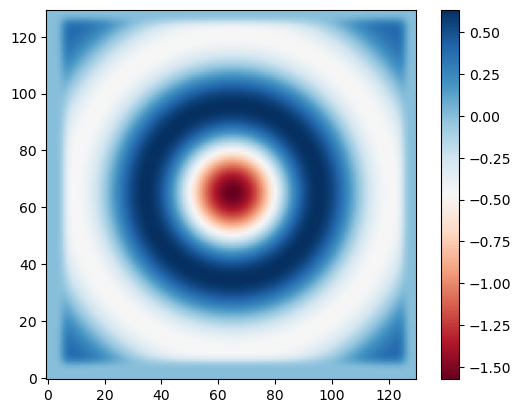

In [21]:
# Solver Setup
geo_cart = photonics.CartesianFDFDGeometry(Nx, Ny, Npml, Npml, dl, dl)
prob_cart = photonics.Photonics_TM_FDFD(
    omega, geo_cart, chi, des_mask_cart, ji_cart, chi_background=chi_bg_cart, sparseQCQP=True
)

ei_cart = prob_cart.get_ei(ji_cart, update=True)
vac_ldos_cart = -np.sum(0.5 * np.real(ji_cart.conj() * ei_cart) * dl**2)
plt.imshow(ei_cart.T.real, origin='lower', cmap='RdBu')
plt.colorbar()
print(f"Cartesian Vacuum LDOS: {vac_ldos_cart:.4f}")

# Objective: Maximize LDOS
ei_des_cart = ei_cart[des_mask_cart]
s0_cart = -0.25 * 1j * omega * ei_des_cart.conj() * dl**2
ndof = np.sum(des_mask_cart)
A0_cart = sp.csc_array(np.zeros((ndof, ndof), dtype=complex))
prob_cart.set_objective(A0=A0_cart, s0=s0_cart, c0=vac_ldos_cart, denseToSparse=True)

# QCQP Setup
prob_cart.setup_QCQP(Pdiags='global', verbose=1)
res_cart = prob_cart.bound_QCQP(method='bfgs')
print(f"Cartesian Bound: {res_cart[0]:.4f}")
print(f"Cartesian Enhancement Bound: {res_cart[0]/vac_ldos_cart:.4f}")

## 2. Polar Coordinates

In [10]:
wvlgth = 1.0
Qabs = np.inf # supports complex frequency, test by setting finite Qabs
omega = 2*np.pi / wvlgth * (1 + 1j/2/Qabs)

R_nonpml = 3.0 # center circle radius
w_pml = 0.5 # surrounding pml thickness
R_tot = R_nonpml + w_pml # total computational domain radius
R_i = R_inner # inner radius of the cavity
R_o = R_outer # outer radius of the cavity
assert R_o < R_nonpml, "Outer radius must be within non-PML region"

gpr = 20
dr = 1.0/gpr # radial grid size
Nr = int(np.round(R_tot / dr))
Npml = int(np.round(w_pml / dr))
Nr_i = int(np.round(R_i / dr)) # inner radius grid point
Nr_o = int(np.round(R_o / dr)) # outer radius grid point
Nphi = 100
n_sectors = 1
Nphi_sector = int(Nphi/n_sectors)  # azimuthal points in one sector

assert Nphi % n_sectors == 0, "Nphi must be divisible by n_sectors"

In [11]:
# Normalize source so integrated current in the central pixel = 1
J_r = np.zeros(Nr)
J_r[0] = 1.0 / (np.pi * dr**2)  # central pixel current density = 1/area
J = np.kron(np.ones(Nphi_sector), J_r)
J_full = expand_symmetric_field(J, n_sectors, Nr)
r_grid = (np.arange(Nr) + 0.5) * dr

# Design Mask
des_mask_polar = np.zeros((Nr, Nphi), dtype=bool)
for i, r in enumerate(r_grid):
    if R_inner <= r <= R_outer:
        des_mask_polar[i, :] = True
ndof = np.sum(des_mask_polar)

# Use radial spacing 'dr' for polar geometry
geo_polar = photonics.PolarFDFDGeometry(Nphi, Nr, Npml, dr)

# Solver Setup
prob_polar = photonics.Photonics_TM_Polar_FDFD(
    omega, geo_polar, chi, des_mask_polar, J, sparseQCQP=False
)

prob_polar.setup_EM_solver()
phi_grid_sector, r_grid, phi_grid_full = prob_polar.EM_solver.get_symmetric_grids()
areas = prob_polar.EM_solver.get_pixel_areas()

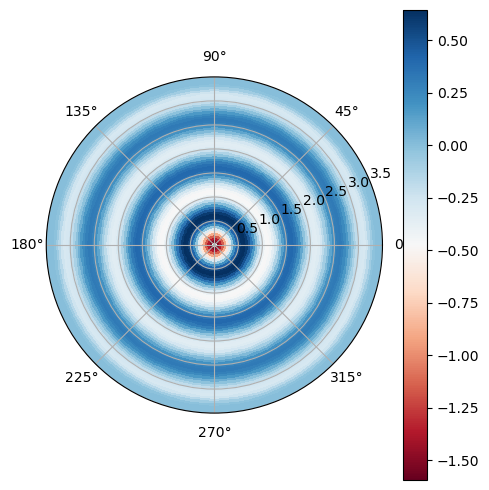

vac_ldos_polar: 0.7974144739339688


NameError: name 'vac_ldos_cart' is not defined

In [12]:
ei = prob_polar.get_ei()
plot_real_polar_field(np.real(ei), phi_grid_sector, r_grid, cmap='RdBu')
# Evaluate vacuum LDOS (per-sector J, multiply by n_sectors)
vac_ldos_polar = -0.5 * np.real(J.conj().dot(areas * ei)) * n_sectors
print(f'vac_ldos_polar: {vac_ldos_polar}')
print(f'vac_ldos_cart: {vac_ldos_cart}')

In [8]:
ei_des_polar = ei[prob_polar.des_mask.flatten(order='F')]
s0_polar = -0.25 * 1j * omega * ei_des_polar.conj()
ndof = np.sum(prob_polar.des_mask)
A0_polar = sp.csc_array(np.zeros((ndof, ndof), dtype=complex))
prob_polar.set_objective(A0=A0_polar, s0=s0_polar, c0=vac_ldos_polar, denseToSparse=False)

prob_polar.setup_QCQP(Pdiags='global', verbose=1)
res_polar = prob_polar.bound_QCQP(method='bfgs')
print(f"Polar Bound: {res_polar[0]:.4f}")
print(f"Polar Enhancement Bound: {res_polar[0]/vac_ldos_polar:.4f}")

<string>:13: UserWarning: If both ji and ei are specified then ji is ignored.


Precomputed 2 A matrices and Fs vectors.


ValueError: Could not find a feasible point for the dual problem.

In [26]:

# QCQP Setup


## 3. Comparison and GCD

We expect the enhancement bounds (Purcell factors) to be similar, though differences in discretization near the singularity (source) will cause some discrepancy in the absolute vacuum LDOS.

In [27]:
print(f"Cartesian Enhancement: {res_cart[0]/vac_ldos_cart:.4f}")
print(f"Polar Enhancement:     {res_polar[0]/vac_ldos_polar:.4f}")

Cartesian Enhancement: 46966.7187
Polar Enhancement:     499176901826.0638


### Running GCD
Now we run General Constraint Descent to tighten the bounds for both cases.

In [28]:
gcd_params = gcd.GCDHyperparameters(
    max_proj_cstrt_num=16,
    max_gcd_iter_num=20,
    gcd_iter_period=5,
    gcd_tol=1e-3
)

print("Running GCD on Cartesian...")
t0 = time.time()
prob_cart.QCQP.run_gcd(gcd_params)
print(f"Cartesian GCD Time: {time.time()-t0:.2f}s")
print(f"Cartesian GCD Bound: {prob_cart.QCQP.current_dual:.4f}")
print(f"Cartesian GCD Enhancement: {prob_cart.QCQP.current_dual/vac_ldos_cart:.4f}")

print("\nRunning GCD on Polar...")
t0 = time.time()
prob_polar.QCQP.run_gcd(gcd_params)
print(f"Polar GCD Time: {time.time()-t0:.2f}s")
print(f"Polar GCD Bound: {prob_polar.QCQP.current_dual:.4f}")
print(f"Polar GCD Enhancement: {prob_polar.QCQP.current_dual/vac_ldos_polar:.4f}")

Running GCD on Cartesian...
Precomputed 2 A matrices and Fs vectors.
At GCD iteration #1, best dual bound found is             37034.934459796415.
At GCD iteration #2, best dual bound found is             41.341934752358426.
At GCD iteration #3, best dual bound found is             35.10317103810863.
At GCD iteration #4, best dual bound found is             32.01687685841505.
At GCD iteration #5, best dual bound found is             30.871357606991705.
At GCD iteration #6, best dual bound found is             29.047420583829265.
At GCD iteration #7, best dual bound found is             27.357924053907528.
At GCD iteration #8, best dual bound found is             26.55751754663287.
At GCD iteration #9, best dual bound found is             26.240107280088722.
At GCD iteration #10, best dual bound found is             25.991684658343864.
At GCD iteration #11, best dual bound found is             25.849324952523478.
At GCD iteration #12, best dual bound found is             25.769905177255